# Predicting Customer Churn for SyriaTel

**Problem Type:** Binary Classification

## Business Understanding

Customer churn is a major concern for telecommunications companies, as acquiring new customers is often significantly more expensive than retaining existing ones. SyriaTel, a telecommunications provider, is interested in proactively identifying customers who are likely to stop doing business with the company.

The primary stakeholder for this project is **SyriaTel’s customer retention and revenue teams.** By accurately predicting which customers are at risk of churning, the company can target these customers with retention strategies such as personalized offers, improved customer support, or contract incentives.

This problem is well-suited for a machine learning classification approach because customer churn is influenced by multiple interacting factors, such as service usage, customer service interactions, and plan characteristics. These are difficult to capture using simple rules or descriptive analysis alone.



## Data Understanding

The dataset used in this project comes from [SyriaTel](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset) and contains customer-level information related to service usage, account details, and customer service interactions.

Each row represents a single customer, and the target variable, `churn`, indicates whether the customer discontinued service. This makes the task a binary classification problem.

The dataset includes a mix of numeric and categorical variables, such as:
- Usage statistics (e.g., total day, evening, and night minutes)
- Customer service interaction metrics
- Plan-related indicators (e.g., international plan, voicemail plan)

Understanding the structure and composition of the data is critical for selecting appropriate preprocessing steps and machine learning models.


In [24]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, confusion_matrix, accuracy_score

from sklearn.tree import DecisionTreeClassifier

In [25]:
# Loading and Inspecting Data

# Loading data to a Pandas Dataframe
df = pd.read_csv('DATA/bigml_59c28831336c6604c800002a.csv')

# Inspecting Dataframe
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In below cell, we will look at the clolumns and their repective data types

There are 3333 rows and 21 columns. (non-null)

In [26]:
# Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [27]:
# Check class balance
df["churn"].value_counts(normalize=True)

churn
False    0.855086
True     0.144914
Name: proportion, dtype: float64

## Data Preparation

Before modeling, we will prepare the data  to ensure that the models generalize well to unseen customers.

Key preparation steps include:
- Separating the target variable (`churn`) from the feature set
- Removing identifier columns such as state and phone number, which do not provide predictive value
- Splitting the data into training and testing sets prior to preprocessing to prevent data leakage
- Encoding categorical variables using one-hot encoding
- Scaling numeric features for models sensitive to feature magnitude

All preprocessing transformations will be fit on the training data only and then applied to the test data to ensure a realistic evaluation of model performance.


In [28]:
# Separate target and features
# Target
y = df["churn"]

# Features
X = df.drop(columns=["churn", "state", "phone number"])

In [29]:
# Train-test-split (BEFORE preprocessing)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

# Identify categorical and numerical columns
cat_cols = X_train.select_dtypes(include="object").columns
num_clos = X_train.select_dtypes(exclude="object").columns

cat_cols, num_clos

(Index(['international plan', 'voice mail plan'], dtype='object'),
 Index(['account length', 'area code', 'number vmail messages',
        'total day minutes', 'total day calls', 'total day charge',
        'total eve minutes', 'total eve calls', 'total eve charge',
        'total night minutes', 'total night calls', 'total night charge',
        'total intl minutes', 'total intl calls', 'total intl charge',
        'customer service calls'],
       dtype='object'))

In [30]:
# One-hot encode categorical variables (fit on train only)
ohe = OneHotEncoder(drop="first", sparse_output=False, handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

In [31]:
# Scaling numeric features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_clos])
X_test_num = scaler.transform(X_test[num_clos])

In [32]:
# Combining processed features
X_train_processed = np.hstack([X_train_num,X_train_cat])
X_test_processed = np.hstack([X_test_num,X_test_cat]) 

## Modeling

We will use an iterative modeling approach to evaluate multiple classification algorithms and improve predictive performance. We will begin with simple, interpretable baseline models and then apply hyperparameter tuning to improve performance while controlling for overfitting.

Four models to train and evaluate:
1. Baseline Logistic Regression  
2. Tuned Logistic Regression  
3. Baseline Decision Tree (CART)  
4. Tuned Decision Tree


### Baseline Model 1: Logistic Regression

Logistic regression is selected as the first baseline model due to its interpretability and strong performance on binary classification problems. It provides a useful benchmark for evaluating whether more complex models meaningfully improve predictive performance.


In [33]:
#  Model 1 - Baseline Logistic regression
logreg_baseline = LogisticRegression(max_iter=1000,random_state=42)
logreg_baseline.fit(X_train_processed,y_train)
y_pred_logreg_base = logreg_baseline.predict(X_test_processed)

In [34]:
# Evaluation
recall_logreg_base = recall_score(y_test, y_pred_logreg_base)
precision_logreg_base = precision_score(y_test, y_pred_logreg_base)
f1_logreg_base = f1_score(y_test, y_pred_logreg_base)
accuracy_logreg_base = accuracy_score(y_test, y_pred_logreg_base)

recall_logreg_base, precision_logreg_base, f1_logreg_base, accuracy_logreg_base


(0.192, 0.5714285714285714, 0.2874251497005988, 0.8573141486810552)

In [35]:
print(classification_report(y_test, y_pred_logreg_base))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred_logreg_base))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92       709
        True       0.57      0.19      0.29       125

    accuracy                           0.86       834
   macro avg       0.72      0.58      0.60       834
weighted avg       0.83      0.86      0.83       834


Confusion Matrix:
[[691  18]
 [101  24]]


### Model 2: Tuned Logistic Regression

To improve upon the baseline logistic regression model, we will adjust hyperparameters to control model complexity and regularization strength. In particular, the regularization parameter `C` is tuned to balance bias and variance.

This step allows us to assess whether modest increases in model flexibility lead to improved generalization performance.


In [36]:
# Model 2 - Tuned Logistic regression

logreg_tuned = LogisticRegression(C=10,max_iter=1000,random_state=42)

logreg_tuned.fit(X_train_processed, y_train)

y_pred_logreg_tuned = logreg_tuned.predict(X_test_processed)


In [37]:
# Evaluation
recall_logreg_tuned = recall_score(y_test, y_pred_logreg_tuned)
precision_logreg_tuned = precision_score(y_test, y_pred_logreg_tuned)
f1_logreg_tuned = f1_score(y_test, y_pred_logreg_tuned)
accuracy_logreg_tuned = accuracy_score(y_test, y_pred_logreg_tuned)

recall_logreg_tuned, precision_logreg_tuned, f1_logreg_tuned,accuracy_logreg_tuned 


(0.184, 0.5897435897435898, 0.28048780487804875, 0.8585131894484412)

In [38]:
print(classification_report(y_test, y_pred_logreg_tuned))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred_logreg_tuned))

              precision    recall  f1-score   support

       False       0.87      0.98      0.92       709
        True       0.59      0.18      0.28       125

    accuracy                           0.86       834
   macro avg       0.73      0.58      0.60       834
weighted avg       0.83      0.86      0.83       834


Confusion Matrix:
[[693  16]
 [102  23]]


### Baseline Model 3: Decision Tree Classifier

We will train a decision tree classifier using the CART algorithm as a nonparametric alternative to logistic regression. Decision trees are capable of modeling nonlinear relationships and interactions between features without requiring feature scaling.

This model serves as a baseline nonparametric approach for comparison.


In [39]:
# Model 3 - Baseline Decision Tree
dt_baseline = DecisionTreeClassifier(random_state=42)

dt_baseline.fit(X_train_processed, y_train)

y_pred_dt_base = dt_baseline.predict(X_test_processed)


In [40]:
# Evaluation
recall_dt_base = recall_score(y_test, y_pred_dt_base)
precision_dt_base = precision_score(y_test, y_pred_dt_base)
f1_dt_base = f1_score(y_test, y_pred_dt_base)
accuracy_dt_base = accuracy_score(y_test, y_pred_dt_base)

recall_dt_base, precision_dt_base, f1_dt_base , accuracy_dt_base


(0.744, 0.6788321167883211, 0.7099236641221374, 0.9088729016786571)

In [41]:
print(classification_report(y_test, y_pred_dt_base))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt_base))

              precision    recall  f1-score   support

       False       0.95      0.94      0.95       709
        True       0.68      0.74      0.71       125

    accuracy                           0.91       834
   macro avg       0.82      0.84      0.83       834
weighted avg       0.91      0.91      0.91       834


Confusion Matrix:
[[665  44]
 [ 32  93]]


### Model 4: Tuned Decision Tree Classifier

To reduce overfitting and improve generalization, the decision tree model will be tuned by constraining its depth and minimum samples per leaf. These hyperparameters help limit model complexity while preserving predictive signal.

This tuned model represents the final nonparametric candidate.


In [42]:
# Model 4: Tuned Decision Tree (full hyperparameter tuning)
dt_tuned = DecisionTreeClassifier(
    criterion='gini',          # Split quality measure ('gini' or 'entropy')
    splitter='best',           # How splits are chosen ('best' or 'random')
    max_depth=6,               # Limit depth to reduce overfitting
    min_samples_split=10,      # Minimum samples required to split an internal node
    min_samples_leaf=20,       # Minimum samples required in a leaf node
    max_features=None,         # Max features considered at each split
    random_state=42,
    class_weight='balanced'    # Adjust for class imbalance
)
dt_tuned.fit(X_train_processed, y_train)

y_pred_dt_tuned = dt_tuned.predict(X_test_processed)


In [43]:
# Evaluation
recall_dt_tuned = recall_score(y_test, y_pred_dt_tuned)
precision_dt_tuned = precision_score(y_test, y_pred_dt_tuned)
f1_dt_tuned = f1_score(y_test, y_pred_dt_tuned)
accuracy_dt_tuned = accuracy_score(y_test, y_pred_dt_tuned)

recall_dt_tuned, precision_dt_tuned, f1_dt_tuned, accuracy_dt_tuned


(0.768, 0.75, 0.7588932806324111, 0.9268585131894485)

In [44]:
print(classification_report(y_test, y_pred_dt_tuned))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt_tuned))


              precision    recall  f1-score   support

       False       0.96      0.95      0.96       709
        True       0.75      0.77      0.76       125

    accuracy                           0.93       834
   macro avg       0.85      0.86      0.86       834
weighted avg       0.93      0.93      0.93       834


Confusion Matrix:
[[677  32]
 [ 29  96]]


## Evaluation

We will evaluate model performance using recall as the primary metric. **In the context of customer churn, false negatives (failing to identify a customer who will churn) are more costly than false positives**, as missed churners represent lost revenue opportunities.

Secondary metrics such as precision and F1-score were also examined to provide a more complete understanding of model behavior.

Performance was evaluated on a held-out test dataset to ensure that results reflect how the models would perform on unseen customers.


In [45]:
# Comparison Table of All Models
model_results = pd.DataFrame({
    "Model": [
        "Baseline Logistic Regression",
        "Tuned Logistic Regression",
        "Baseline Decision Tree",
        "Tuned Decision Tree"
    ],
    "Recall": [
        recall_logreg_base,
        recall_logreg_tuned,
        recall_dt_base,
        recall_dt_tuned
    ],
    "Precision": [
        precision_logreg_base,
        precision_logreg_tuned,
        precision_dt_base,
        precision_dt_tuned
    ],
    "F1 Score": [
        f1_logreg_base,
        f1_logreg_tuned,
        f1_dt_base,
        f1_dt_tuned
    ],
    "Accuracy": [
        accuracy_logreg_base,
        accuracy_logreg_tuned,
        accuracy_dt_base,
        accuracy_dt_tuned
    ]
})

model_results


,Model,Recall,Precision,F1 Score,Accuracy
0,Baseline Logistic Regression,0.192,0.571429,0.287425,0.857314
1,Tuned Logistic Regression,0.184,0.589744,0.280488,0.858513
2,Baseline Decision Tree,0.744,0.678832,0.709924,0.908873
3,Tuned Decision Tree,0.768,0.750000,0.758893,0.926859


**Observations:**

- The **Tuned Decision Tree** achieves the highest recall, which is the most important metric for reducing missed churners.
- Precision and F1-score are also strong, indicating the model balances identifying churners without generating excessive false positives.
- Logistic regression models provide interpretable baselines but underperform compared to the tuned tree for this dataset.


### Final Model 

After comparing all four models, the tuned decision tree model will be selected as the final model based on its balance of recall, interpretability, and generalization performance.


**Best Model:** Tuned Decision Tree  
**Rationale:** Highest recall ensures that most at-risk customers are identified. Handles non-linear relationships and multiple categorical features effectively. 

SyriaTel can proactively target predicted churners with retention strategies (e.g., personalized offers, improved customer support, or contract incentives), minimizing revenue loss from unexpected churn while maintaining actionable precision.


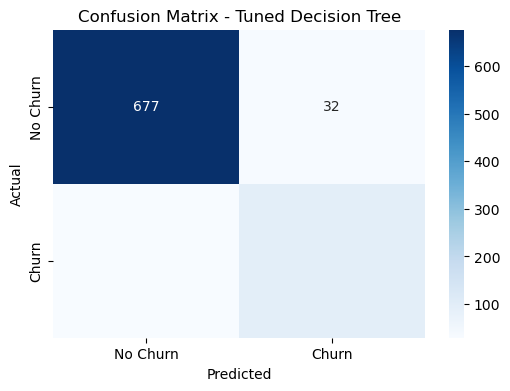

True Negatives: 677, False Positives: 32
False Negatives: 29, True Positives: 96


In [46]:
# Confusion Matrix for Final Model (Tuned Decision Tree)

cm = confusion_matrix(y_test, y_pred_dt_tuned)
cm_labels = ['No Churn', 'Churn']

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tuned Decision Tree')
plt.show()

# TN, FP, FN, TP counts
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}, False Positives: {fp}")
print(f"False Negatives: {fn}, True Positives: {tp}")


## Recommendation

Based on the analysis of four models, the **Tuned Decision Tree** is recommended as the primary predictive model for SyriaTel’s customer churn as highlighted below:

- **Highest Recall:** Minimizes missed churners, which is critical to protecting revenue.
- **Strong F1-Score and Precision:** Ensures predictions are actionable without generating excessive false positives.
- **Handles Complex Patterns:** Captures non-linear interactions and categorical feature effects better than logistic regression.

